# Trabalho 1 - Parte II - Projeto de Análise de Dados

## Componentes

- Raphael Ramos
- Vitor Gabriel

## Importações de módulos

In [70]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.fmt import fmt_date

data_path = '../data'

## Importar conjuntos de dados

In [71]:
# Carregar ambos os conjuntos de dados de qualidade do ar e clima
df_air_quality = pd.read_csv('{}/india_air_quality_daily_2015_to_2020.csv'.format(data_path))
df_weather = pd.read_csv('{}/india_weather_daily_data_combined_2010_to_2019.csv'.format(data_path))


## União dos conjuntos de dados

Unir os dois conjuntos de dados (qualide do ar e clima), considerando a cidade e a data como a chave de união

In [72]:
common_cities = np.intersect1d(df_weather['city_name'].unique(), df_air_quality['City'].unique())

# Filtrar cidades comuns
df_air_quality_c = df_air_quality[df_air_quality['City'].isin(common_cities)].copy()
df_weather_c = df_weather[df_weather['city_name'].isin(common_cities)].copy()

# Unir os dataframes com a estratégia de INNER JOIN, para que tenhamos datas não nulas em ambos
df = pd.merge(df_air_quality_c, df_weather_c, how="inner", left_on=["City", "Date"], right_on=["city_name", "datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12774 entries, 0 to 12773
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   City                         12774 non-null  object 
 1   Date                         12774 non-null  object 
 2   PM2.5                        10247 non-null  float64
 3   PM10                         4634 non-null   float64
 4   NO                           10556 non-null  float64
 5   NO2                          10596 non-null  float64
 6   NOx                          10724 non-null  float64
 7   NH3                          6145 non-null   float64
 8   CO                           11860 non-null  float64
 9   SO2                          10353 non-null  float64
 10  O3                           10334 non-null  float64
 11  Benzene                      11317 non-null  float64
 12  Toluene                      10693 non-null  float64
 13  Xylene          

Visualização das datas de inicio e fim do dataset unido, em relacão a uma cidade específica

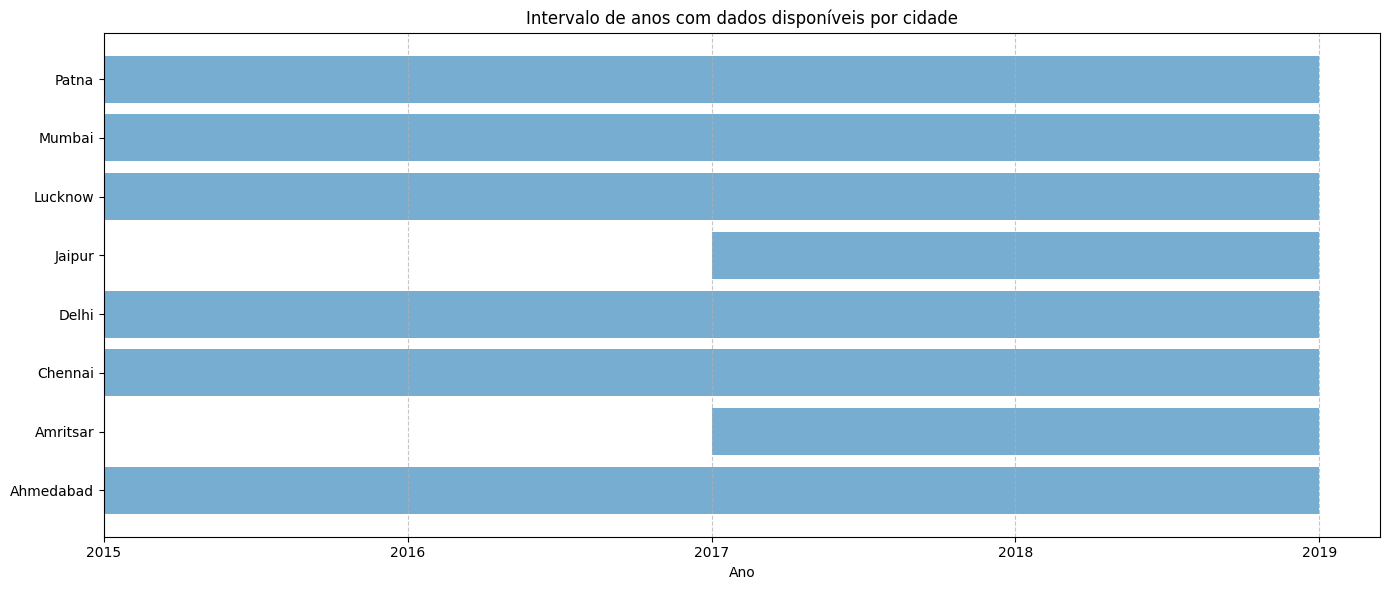

In [73]:
# Supondo que a coluna 'Date' já esteja em datetime
df['Date'] = pd.to_datetime(df['Date'])

start_dates = []
end_dates = []
delta = []

for city in common_cities:
    df_filtered_by_city = df[df['City'] == city]
    dates = df_filtered_by_city['Date']
    y_min = dates.min().year
    y_max = dates.max().year
    start_dates.append(y_min)
    end_dates.append(y_max)
    delta.append(y_max - y_min)

# Definindo o menor e maior ano para os ticks do eixo x
x_min = min(start_dates)
x_max = max(end_dates)

# Gráfico
plt.figure(figsize=(14, 6))
plt.barh(y=common_cities, width=delta, left=start_dates, alpha=0.6)
plt.xlabel("Ano")
plt.title("Intervalo de anos com dados disponíveis por cidade")
plt.xticks(ticks=range(x_min, x_max + 1))  # Apenas anos inteiros
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Análises

### Como o AQI das cidades se distribuiu ao longo dos anos?

Agrupar as distribuições de AQI por ano em cada cidade em histogramas

<class 'pandas.core.frame.DataFrame'>
Index: 11564 entries, 28 to 25721
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    11564 non-null  object 
 1   AQI     11564 non-null  float64
 2   Date    11564 non-null  object 
dtypes: float64(1), object(2)
memory usage: 361.4+ KB
None


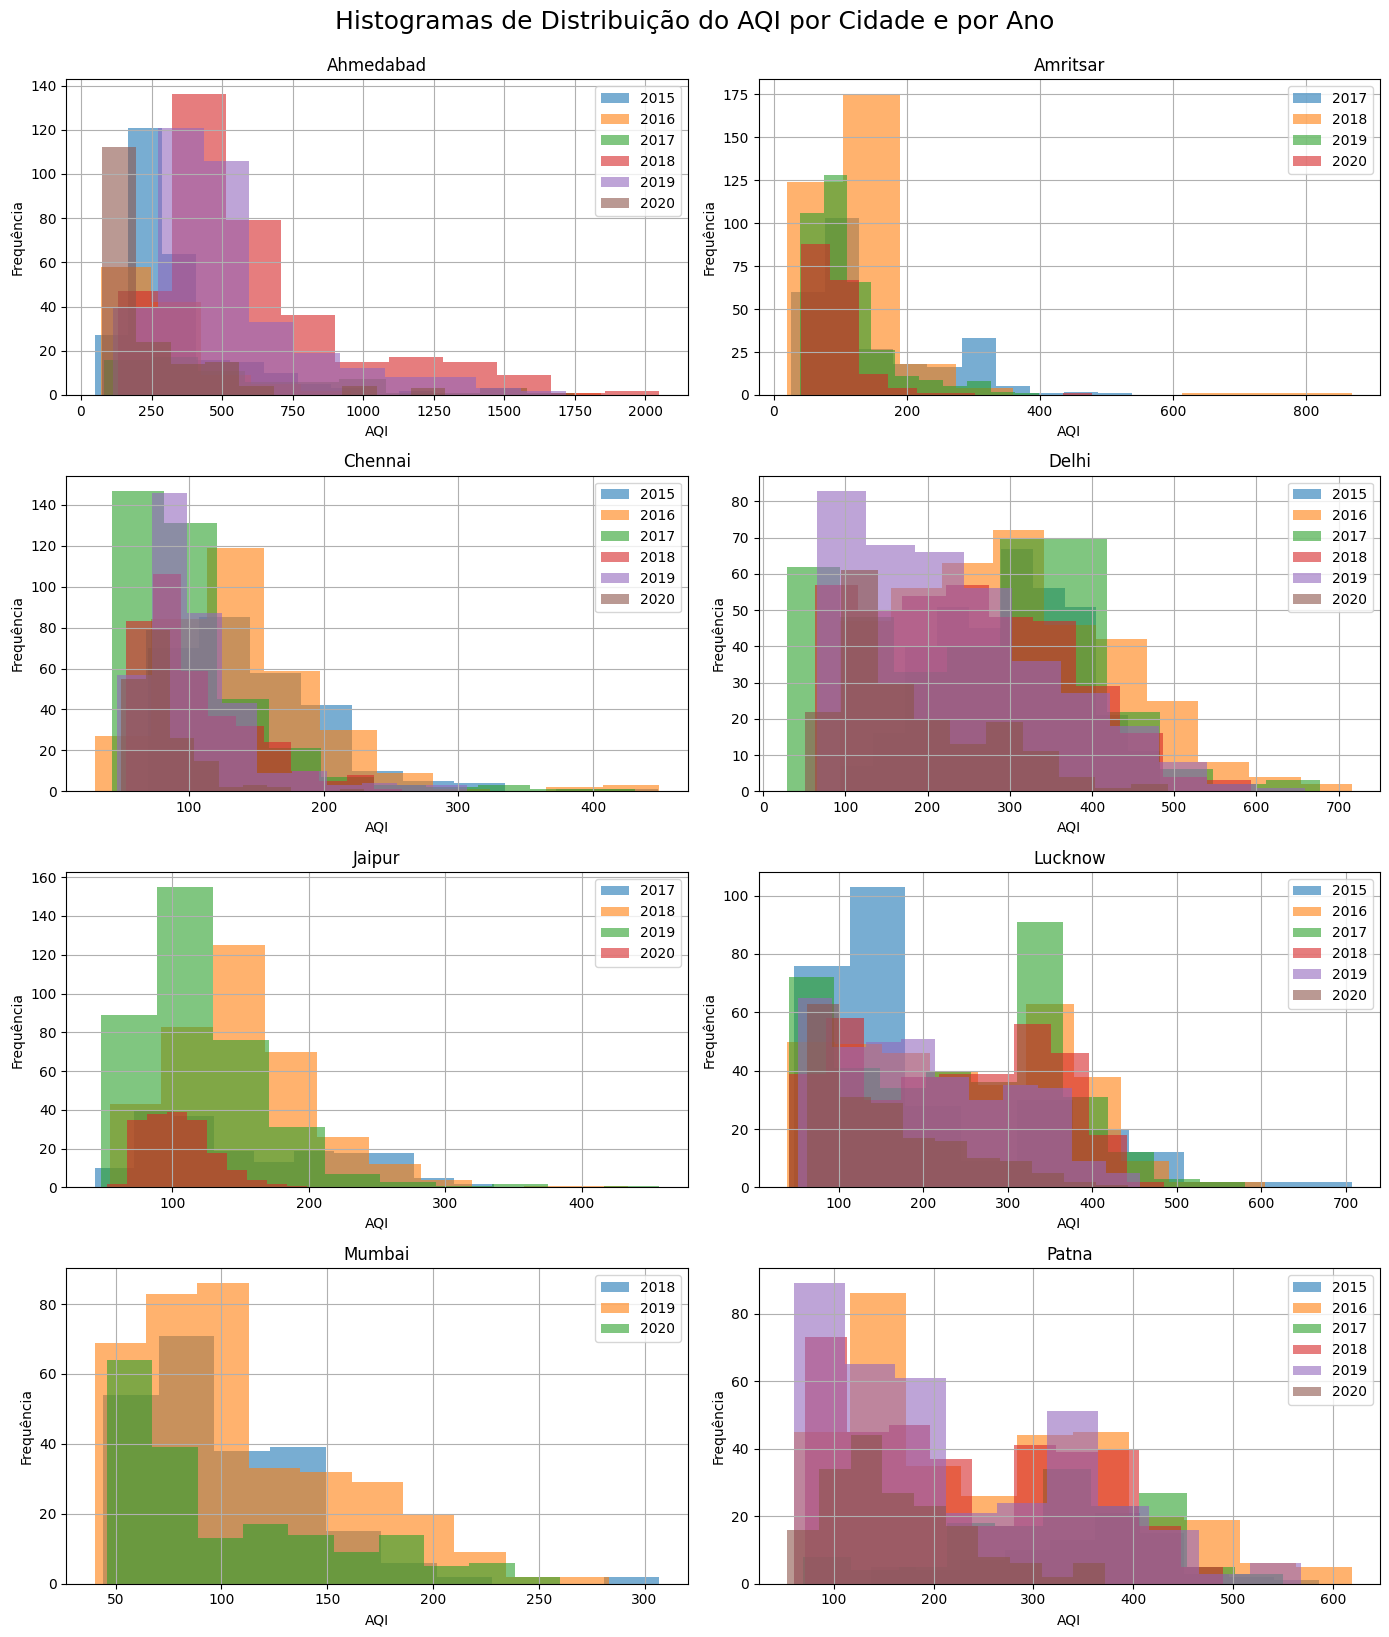

In [74]:
# Filtrar por City, AQI e Date
air_quality_aqi_c = df_air_quality_c[['City', 'AQI', 'Date']].copy()

# Remover linhas com AQI null
air_quality_aqi_c = air_quality_aqi_c.dropna()
print(air_quality_aqi_c.info())

# Converter a coluna 'Date' para datetime e extrair o ano
air_quality_aqi_c['Date'] = pd.to_datetime(air_quality_aqi_c['Date'])
air_quality_aqi_c['Year'] = air_quality_aqi_c['Date'].dt.year

# Certifique-se de que a coluna 'Date' está em formato datetime e extraia o ano
air_quality_aqi_c['Date'] = pd.to_datetime(air_quality_aqi_c['Date'])
air_quality_aqi_c['Year'] = air_quality_aqi_c['Date'].dt.year

# Configurar grid 4x2 para 8 cidades
cities = air_quality_aqi_c['City'].unique()
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

for i, city in enumerate(cities):
    ax = axes[i]
    city_data = air_quality_aqi_c[air_quality_aqi_c['City'] == city]
    years = sorted(city_data['Year'].unique())
    
    for year in years:
        year_data = city_data[city_data['Year'] == year]['AQI']
        ax.hist(year_data, bins=10, alpha=0.6, label=str(year))
    
    ax.set_title(f'{city}')
    ax.set_xlabel('AQI')
    ax.set_ylabel('Frequência')
    ax.legend()
    ax.grid(True)

# Remover eixos extras se houver
for j in range(len(cities), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Histogramas de Distribuição do AQI por Cidade e por Ano', fontsize=18, y=1.02)
plt.show()


Padrões de poluição ao longo dos anos
- Ahmedabad e Delhi apresentam uma faixa mais ampla de valores de AQI, com alguns anos registrando valores extremamente altos (até 2000 em Ahmedabad e 700 em Delhi). Isso sugere que essas cidades enfrentaram episódios graves de poluição.
- Chennai e Mumbai têm distribuições concentradas em faixas mais baixas de AQI (menores que 300), indicando uma qualidade do ar relativamente melhor.
- Jaipur, Lucknow, e Patna têm distribuições que sugerem frequentes episódios de AQI moderado a ruim (valores entre 100 e 300), mas sem extremos tão elevados quanto Ahmedabad ou Delhi.

Presença de valores extremos (outliers)

- As caudas longas em cidades como Ahmedabad, Delhi, e Lucknow sugerem a ocorrência de eventos pontuais de poluição extrema.
- Esses eventos podem coincidir com queimadas, festividades com fogos, poluição veicular intensa ou condições climáticas adversas.

Comparações entre cidades

- Cidades do norte da Índia como Delhi, Lucknow e Patna apresentam distribuições mais deslocadas para a direita (maior AQI), o que é consistente com estudos que apontam o norte da Índia como uma das regiões mais poluídas do mundo.
- Cidades costeiras como Mumbai e Chennai têm histogramas com picos em faixas mais baixas de AQI, o que pode refletir maior ventilação natural e dispersão de poluentes.

### Houve diminuição ou aumento do AQI tendo como referência a data mais antiga e a mais recente?

Utilizar um gráfico de barras invertido, em que cada barra representa uma cidade, e na intensidade colocar a variação absoluta do AQI entre o ano mais recente e mais antigo de cada cidade.

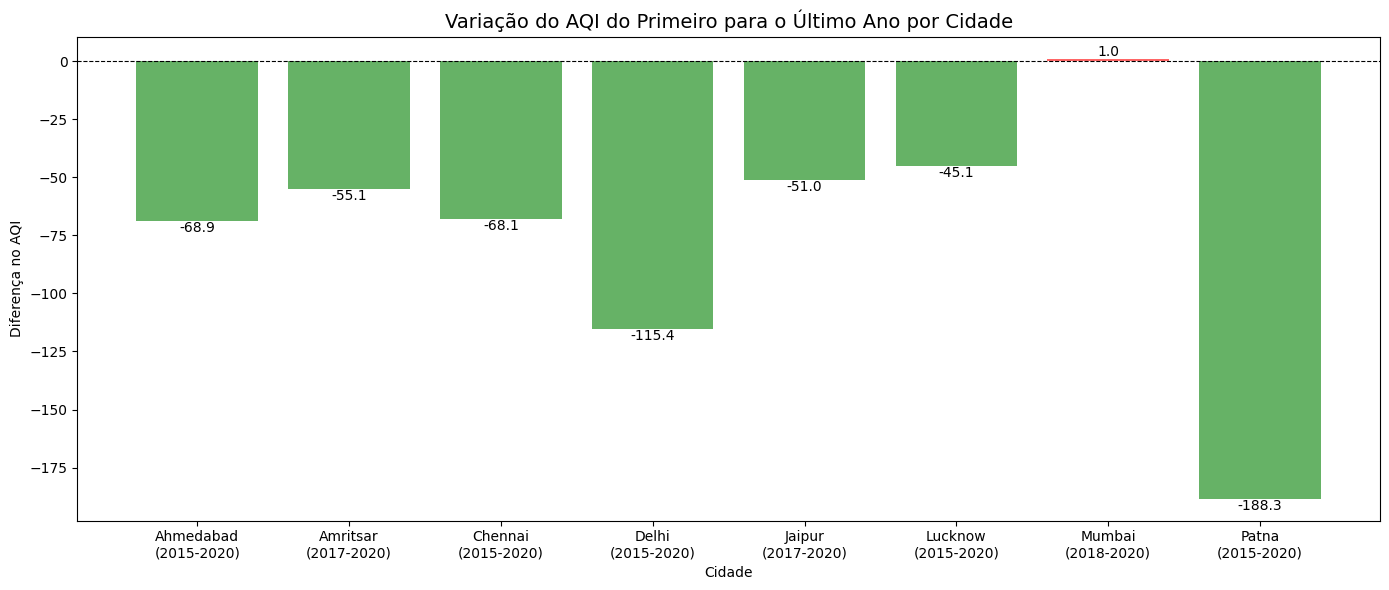

In [75]:
# Certifique-se de que a data está formatada corretamente
air_quality_aqi_c['Date'] = pd.to_datetime(air_quality_aqi_c['Date'])
air_quality_aqi_c['Year'] = air_quality_aqi_c['Date'].dt.year

# Criar um DataFrame para armazenar os resultados
rates = []

# Loop por cidade
for city in air_quality_aqi_c['City'].unique():
    data = air_quality_aqi_c[air_quality_aqi_c['City'] == city]
    
    # Identificar primeiro e último ano com dados
    start_year = data['Year'].min()
    end_year = data['Year'].max()
    
    # Calcular médias do AQI nesses anos
    start_aqi_avg = data[data['Year'] == start_year]['AQI'].mean()
    end_aqi_avg = data[data['Year'] == end_year]['AQI'].mean()
    
    # Calcular diferença e tendência
    diff = end_aqi_avg - start_aqi_avg
    if pd.isna(start_aqi_avg) or pd.isna(end_aqi_avg):
        trend = 'Estável'
    else:
        trend = 'Aumento' if diff > 0 else 'Diminuição' if diff < 0 else 'Estável'
    
    rates.append({
        'City': city,
        'Ano Inicial': start_year,
        'AQI Inicial': start_aqi_avg,
        'Ano Final': end_year,
        'AQI Final': end_aqi_avg,
        'Diferença': diff,
        'Tendência': trend
    })

# Converter em DataFrame
aqi_rates = pd.DataFrame(rates)
aqi_rates.set_index('City', inplace=True)

# Resetar o índice para facilitar a plotagem
aqi_rates = aqi_rates.reset_index()

# Definir cores por tendência
colors_set = aqi_rates['Tendência'].map({
    'Aumento': 'red',
    'Diminuição': 'green',
    'Estável': 'gray'
})

plt.figure(figsize=(14, 6))
bars = plt.bar(aqi_rates['City'], aqi_rates['Diferença'], color=colors_set, alpha=0.6)

# Adicionar anos de início e fim aos rótulos do eixo X
city_labels = [f"{city}\n({start_year}-{end_year})" for city, start_year, end_year in zip(aqi_rates['City'], aqi_rates['Ano Inicial'], aqi_rates['Ano Final'])]
plt.xticks(ticks=range(len(aqi_rates['City'])), labels=city_labels, ha='center')

# Adicionar rótulos de valores
for bar, diff in zip(bars, aqi_rates['Diferença']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{diff:.1f}", 
             ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Variação do AQI do Primeiro para o Último Ano por Cidade', fontsize=14)
plt.xlabel('Cidade')
plt.ylabel('Diferença no AQI')
plt.tight_layout()
plt.show()


Diminuição do AQI
- Patna (-188.3) e Delhi (-115.4) são os destaques com as maiores reduções — indicam melhora significativa na qualidade do ar.
- medabad, Chennai, Jaipur, Lucknow e Amritsar também apresentaram quedas expressivas, sugerindo esforços de mitigação bem-sucedidos ou mudanças ambientais.

Estabilidade
- Mumbai praticamente não mudou (Δ ≈ 1.0), sugerindo um cenário estável, mas sem grandes avanços.

### Correlações entre poluentes

#### Quais poluentes tem mais influência no AQI?

Plotar a matriz de coeficiente de correlação entre os Poluentes do ar e o AQI

<class 'pandas.core.frame.DataFrame'>
Index: 6236 entries, 2123 to 29529
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PM2.5    6236 non-null   float64
 1   PM10     6236 non-null   float64
 2   NO       6236 non-null   float64
 3   NO2      6236 non-null   float64
 4   NOx      6236 non-null   float64
 5   NH3      6236 non-null   float64
 6   CO       6236 non-null   float64
 7   SO2      6236 non-null   float64
 8   O3       6236 non-null   float64
 9   Benzene  6236 non-null   float64
 10  Toluene  6236 non-null   float64
 11  Xylene   6236 non-null   float64
 12  AQI      6236 non-null   float64
dtypes: float64(13)
memory usage: 682.1 KB
None


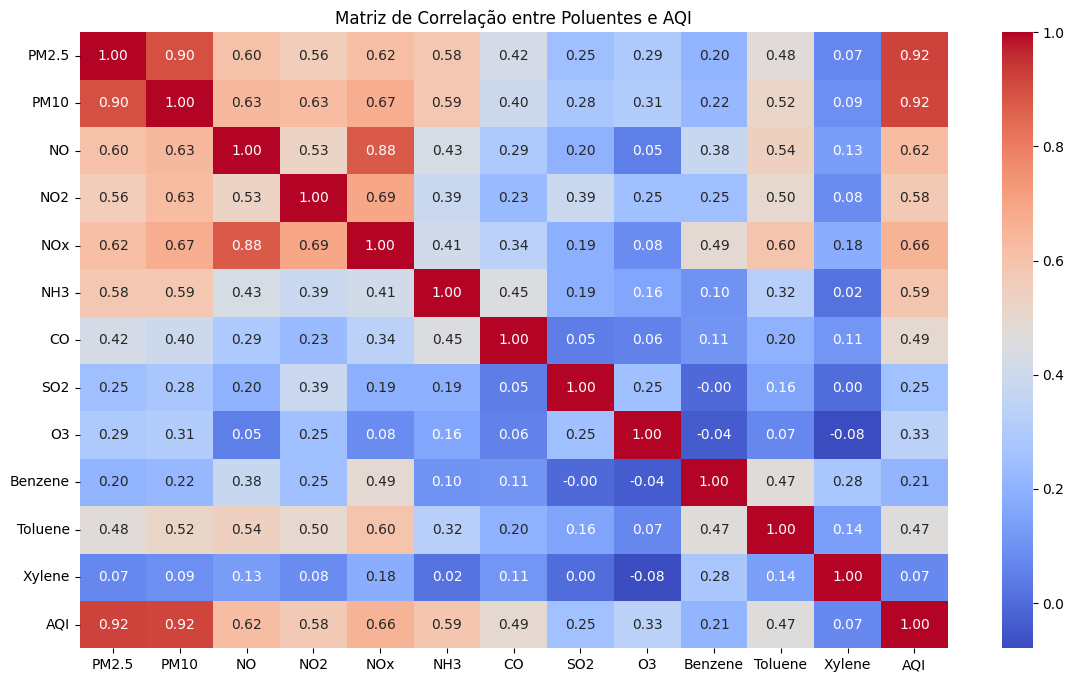

In [76]:
# Selecionar apenas as colunas dos poluentes e do AQI
pollutants_aqi_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
df_air_quality_numeric = df_air_quality[pollutants_aqi_cols].copy()

# Remover linhas com valores faltantes
df_clean = df_air_quality_numeric.dropna()
print(df_clean.info())

# Calcular a matriz de coeficientes de correlação pelo metodo de Pearson
correlation_matrix = df_clean.corr(method='pearson')

# Visualizá-la com um mapa de calor
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação entre Poluentes e AQI")
plt.show()

Com base na matriz de correlação exibida, os poluentes com maior forte influência no AQI (ou seja, com maiores coeficientes de correlação positivos) são o PM2.5 e PM10.

**O que são PM2.5 e PM10?**
- São partículas sólidas ou líquidas suspensas no ar, de diâmetro menor que 2,5 µm ou 10 µm, respectivamente.
- Provêm de fontes como: veículos, queima de combustíveis, poeira do solo, indústrias.
- São perigosas porque podem penetrar profundamente nos pulmões e até entrar na corrente sanguínea.

#### Descoberto esses poluentes, quão forte é a influência deles nas variáveis climáticas?

Plotar as matrizes de correlação entre os Poluentes do ar e a Temperatura aparente média (Celsius), Soma da radiação solar de onda curta (MJ/m2) e Soma da chuva diária (mm)

<class 'pandas.core.frame.DataFrame'>
Index: 4550 entries, 1594 to 12773
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PM2.5                      4550 non-null   float64
 1   PM10                       4550 non-null   float64
 2   apparent_temperature_mean  4550 non-null   float64
 3   shortwave_radiation_sum    4550 non-null   float64
 4   rain_sum                   4550 non-null   float64
dtypes: float64(5)
memory usage: 213.3 KB
None


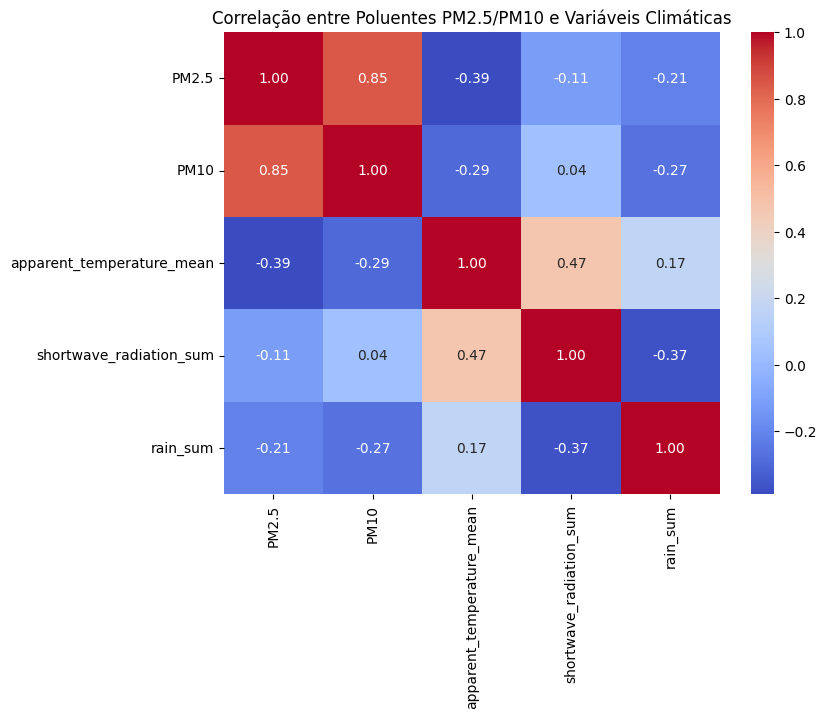

In [77]:
# Selecionar colunas relevantes
weather_parameters_cols = ['apparent_temperature_mean', 'shortwave_radiation_sum', 'rain_sum']
df_weather_airquality_numeric = df[['PM2.5', 'PM10', *weather_parameters_cols]].copy()

# Remover linhas com valores nulos
df_weather_airquality_numeric.dropna(inplace=True)
print(df_weather_airquality_numeric.info())

# Calcular a matriz de correlação
correlation_matrix = df_weather_airquality_numeric.corr(method='pearson')

# Plotar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre Poluentes PM2.5/PM10 e Variáveis Climáticas")
plt.show()

PM2.5 possui
- Correlação Moderada negativa com a temperatura
- Correlação fraca negativa com a radiação solar e a precipitação acumulada

PM10 possui
- Correlação quase nula com a radiação solar, indicando que não a influencia significativamente
- Correlação fraca/moderada negativa com a temperatura, similar ao PM2.5 mas menos acentuado
- Correlação fraca negativa com a precipitação acumulada

De forma geral, o concluimos que o clima tem influência limitada, mas relevante, especialmente a temperatura e a chuva sobre os níveis de material particulado.

Temperaturas mais altas e maior volume de chuva tendem a reduzir PM2.5 e PM10, provavelmente por dispersão e deposição dos poluentes.

**Temperaturas mais altas reduzem PM2.5 e PM10 – por quê?**

Aquecimento do ar faz com que ele suba (efeito de convecção). Isso favorece a dispersão dos poluentes: o ar se movimenta mais, criando correntes que espalham as partículas no espaço, diminuindo sua concentração em áreas específicas. Além disso, dias mais quentes costumam ter mais radiação solar, o que pode acelerar reações químicas que transformam ou degradam alguns poluentes.

Dessa forma, menos partículas finas (PM2.5 e PM10) concentradas perto do solo implicam em um menor valor medido.

**Mais chuva reduz PM2.5 e PM10 – como?**

A precipitação "lava" a atmosfera: as gotas de chuva capturam partículas suspensas no ar durante sua queda. Esse processo é chamado de lavagem úmida atmosférica (wet deposition). Isso remove fisicamente os poluentes do ar, levando-os ao solo ou corpos d'água. 

Logo, após a chuva, o ar tende a estar mais limpo, com concentrações mais baixas de material particulado.
